## 概要
系(prior)が固定されている状況においては、main-networkとsub-networkの時間スケールに差がある場合の方が差がない場合に対してより最適に近いベイズ推定が実現することが示唆されている。

一方、priorが時間的に変化する場合における「対応力」(adjustability)に差があるのかについては明らかになっていない。
ここでは、一定時間経過後にpriorが変化するような状況を考え、その時の推論の様子を調べることで上記の問いを明らかにする。

priorの変化はまずは平均が変わる場合を調べたのち、分散が変わる場合を調べる。さらに、priorが時間変化する際の時間スケールに対する依存性も調べる。


In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [14]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = 1.25
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            if t <= 50:
                true_signal = state_list[0]()
            else:
                true_signal = state_list[1]()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [15]:
def calc_bayesian_optimal(mu_l, sigma_l, mu_p, sigma_p):
    return mu_p * (sigma_l**2/(sigma_p**2+sigma_l**2)) + mu_l * (sigma_p**2/(sigma_p**2+sigma_l**2))

### モデルの読み込み
時間スケールに差がないモデル

In [16]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220528_all_slow/20220528_all_slow.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=0,
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220528_all_slow


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

時間スケールに差があるモデル

In [17]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220528_4/20220528_4.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_slow = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=0,
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_slow.load_state_dict(torch.load(model_path, map_location=device))
model_slow.eval()



model_name:  20220528_4


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

### 平均が変わる場合
- $\mu_p$: -0.5 -> 0.5
- $\sigma_p$: 0.5

In [18]:
state_list = [
    State(mu=-0.5, sigma=0.5),
    State(mu=0.5, sigma=0.5),
]

In [19]:
sample_num = 500
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             
# 時間スケールに差がないモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list_1, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 100)

# 時間スケールに差があるモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list_4, outputs_slow, prior_list, reservoir_list = model_slow(inputs, hidden, reservoir, 100)                                                       


In [20]:
sigma_l = math.sqrt(1/1.25) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(signal_mu_list[:, :], sigma_l, -0.5, 0.5)
bayesian_optimal_b = calc_bayesian_optimal(signal_mu_list[:, :], sigma_l, 0.5, 0.5)

In [21]:
alpha_samples = (bayesian_optimal_b - np.array(outputs[:, :, 0].tolist())) / (bayesian_optimal_b - bayesian_optimal_a)
alpha_samples_slow = (bayesian_optimal_b - np.array(outputs_slow[:, :, 0].tolist())) / (bayesian_optimal_b - bayesian_optimal_a)




In [22]:
alpha = np.mean(alpha_samples, axis=0)
alpha_slow = np.mean(alpha_samples_slow, axis=0)

(-0.2, 1.2)

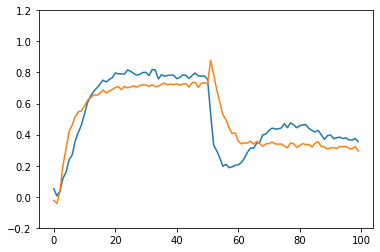

In [23]:
plt.plot(alpha)
plt.plot(alpha_slow)
plt.ylim([-0.2, 1.2])

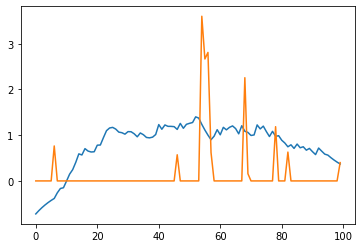

In [24]:
plt.plot(hidden_list_1[0, :, 0].detach().numpy())
plt.plot(hidden_list_4[0, :, 3].detach().numpy())

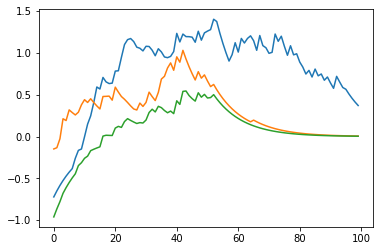

In [25]:
plt.plot(hidden_list_1[0, :, 0].detach().numpy())
plt.plot(hidden_list_1[0, :, 1].detach().numpy())
plt.plot(hidden_list_1[0, :, 2].detach().numpy())

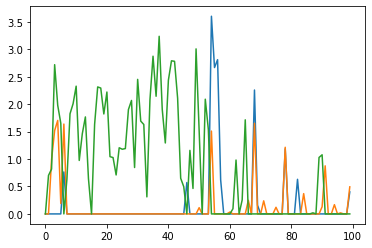

In [26]:
plt.plot(hidden_list_4[0, :, 3].detach().numpy())
plt.plot(hidden_list_4[0, :, 4].detach().numpy())
plt.plot(hidden_list_4[0, :, 6].detach().numpy())

In [27]:
!mkdir -p results/20220524

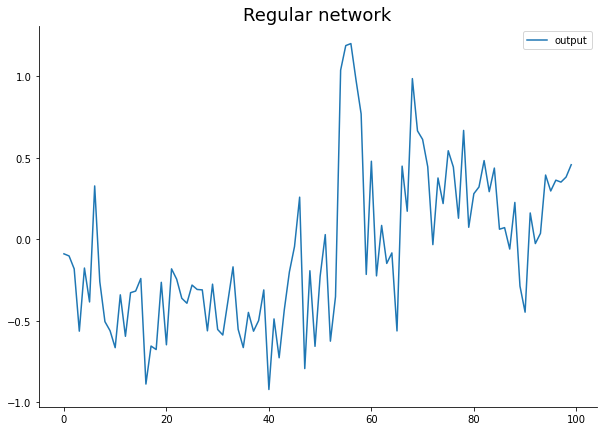

In [30]:
plt.figure(figsize=(10, 7))

# plt.plot(signal_mu_list[0], label='signal')
plt.plot(outputs[0, :, 0].tolist(), label='output')
# plt.plot(true_signal_list[0], label='true value')

plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Regular network', fontsize=18)
# plt.savefig('results/20220524/output.png')
plt.show()

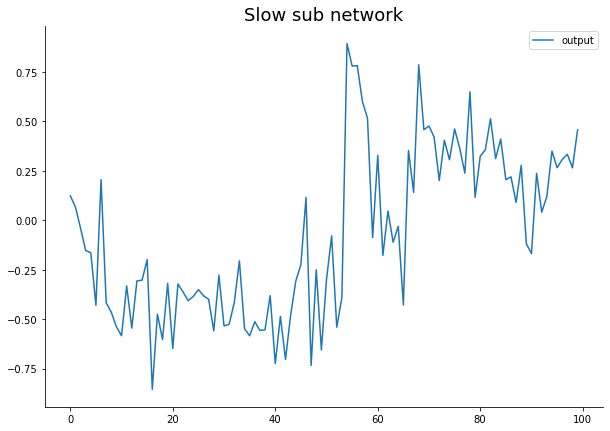

In [31]:
plt.figure(figsize=(10, 7))

# plt.plot(signal_mu_list[0], label='signal')
plt.plot(outputs_slow[0, :, 0].tolist(), label='output')
# plt.plot(true_signal_list[0], label='true value')

plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Slow sub network', fontsize=18)
# plt.savefig('results/20220524/output_slow.png')
plt.show()

### 分散が変わる場合
- $\mu_p$: 0
- $\sigma_p$: 0.8 -> 0.1

In [54]:
state_list = [
    State(mu=0, sigma=0.8),
    State(mu=0, sigma=0.05),
]

In [55]:
sample_num = 1000
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             
# 時間スケールに差がないモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 100)

# 時間スケールに差があるモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_slow, prior_list, reservoir_list = model_slow(inputs, hidden, reservoir, 100)                                                       


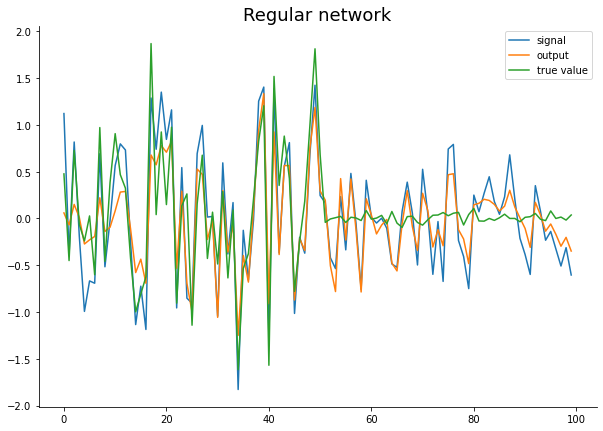

In [56]:
plt.figure(figsize=(10, 7))

plt.plot(signal_mu_list[0], label='signal')
plt.plot(outputs[0, :, 0].tolist(), label='output')
plt.plot(true_signal_list[0], label='true value')

plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Regular network', fontsize=18)
plt.show()

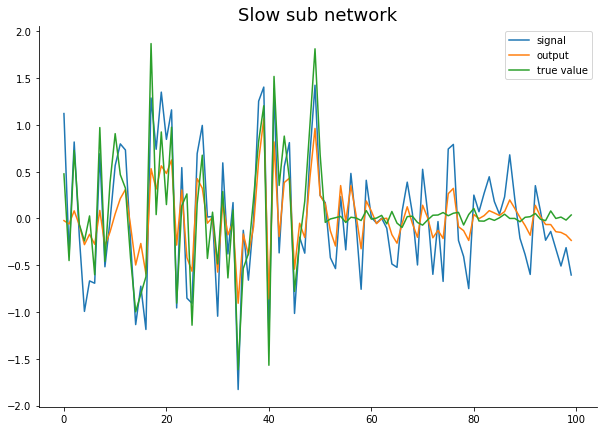

In [57]:
plt.figure(figsize=(10, 7))

plt.plot(signal_mu_list[0], label='signal')
plt.plot(outputs_slow[0, :, 0].tolist(), label='output')
plt.plot(true_signal_list[0], label='true value')

plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Slow sub network', fontsize=18)
plt.show()

In [58]:
sigma_l = math.sqrt(1/1.25) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(signal_mu_list[:, :], sigma_l, 0, 0.8)
bayesian_optimal_b = calc_bayesian_optimal(signal_mu_list[:, :], sigma_l, 0, 0.05)

In [59]:
norm = bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(100):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples = (bayesian_optimal_b - np.array(outputs[:, :, 0].tolist())) / norm
alpha_samples_slow = (bayesian_optimal_b - np.array(outputs_slow[:, :, 0].tolist())) / norm

alpha = np.mean(alpha_samples, axis=0)
alpha_slow = np.mean(alpha_samples_slow, axis=0)


(-0.2, 1.2)

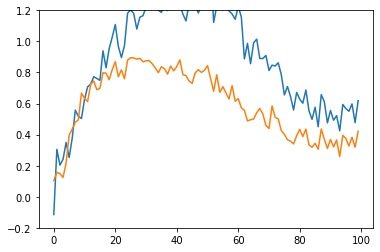

In [60]:
plt.plot(alpha)
plt.plot(alpha_slow)
plt.ylim([-0.2, 1.2])